In [1]:
from caches import LFUCache, NonCache, SimpleCache, LRUCache, GLFUCache, BeladyCache
from cachesim import Status, Request
from cachesim.tools import PBarMixIn
from readers import PopulationReader
import numpy as np
from tqdm.auto import tqdm

In [2]:
count = 1000000
cbase = count // 10
maxsize = cbase // 20
s = 1
HNs = sum([k ** -s for k in range(1, cbase + 1)])

def zipf_pmf(k):
    return k ** -s / HNs

def zipf_cdf(k):
    return sum([x ** -s for x in range(1, k + 1)]) / HNs

zipf = [k ** -s / HNs for k in range(1, cbase + 1)]

In [3]:
class MySimpleCache(PBarMixIn, SimpleCache):
    pass


class MyNonCache(PBarMixIn, NonCache):
    pass

class MyBeladyCache(PBarMixIn, BeladyCache):
    pass


class MyLFUCache(PBarMixIn, LFUCache):
    pass


class MyGLFUCache(PBarMixIn, GLFUCache):
    pass


class MyLRUCache(PBarMixIn, LRUCache):
    pass


reqs = {}
for cache in [MySimpleCache(maxsize=maxsize),
              MyNonCache(),
              MyLFUCache(maxsize=maxsize),
              MyGLFUCache(maxsize=maxsize),
              MyLRUCache(maxsize=maxsize)
              ]:
    reader = PopulationReader(count, cbase, weights=zipf)

    req = list(cache.map(reader))
    reqs[cache.__class__.__name__] = req

    hit = sum(map(lambda r: r.status == Status.HIT, req))
    print(f"Requests: {len(req)}")
    print(f"CHR: {Request.chr(req) * 100:.2f}%")
    print(f"Bytes sent: {sum(r.size for r in req)} B")
    print()

    x = [r.time for r in req]

MySimpleCache: 100%|██████████| 1000000/1000000 [00:02<00:00, 361666.91it/s]


Requests: 1000000
CHR: 62.63%
Bytes sent: 1000000 B



MyNonCache: 100%|██████████| 1000000/1000000 [00:02<00:00, 354712.35it/s]


Requests: 1000000
CHR: 0.00%
Bytes sent: 1000000 B



MyLFUCache: 100%|██████████| 1000000/1000000 [00:43<00:00, 23138.02it/s]


Requests: 1000000
CHR: 72.15%
Bytes sent: 1000000 B



MyGLFUCache: 100%|██████████| 1000000/1000000 [00:50<00:00, 19695.75it/s]


Requests: 1000000
CHR: 74.05%
Bytes sent: 1000000 B



MyLRUCache: 100%|██████████| 1000000/1000000 [00:02<00:00, 434137.82it/s]


Requests: 1000000
CHR: 66.50%
Bytes sent: 1000000 B



In [5]:

requests = [r for r in PopulationReader(count, cbase, weights=zipf)]
fut = [r.hash for r in requests]

cache = BeladyCache(maxsize=maxsize, future = fut)

req = []
for i in tqdm(range(count)):
    try:
        request = cache[requests[i].hash]
        request.retrieve(Status.HIT)
        req.append(request)
    except KeyError:
        requests[i].retrieve(Status.MISS)

        cache.setitem(requests[i].hash, requests[i], i)
        #cache[futu[i].hash] = futu[i]
        req.append(requests[i])

hit = sum(map(lambda r: r.status == Status.HIT, req))
print(f"Requests: {len(req)}")
print(f"CHR: {Request.chr(req) * 100:.2f}%")
print(f"Bytes sent: {sum(r.size for r in req)} B")
print()


  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

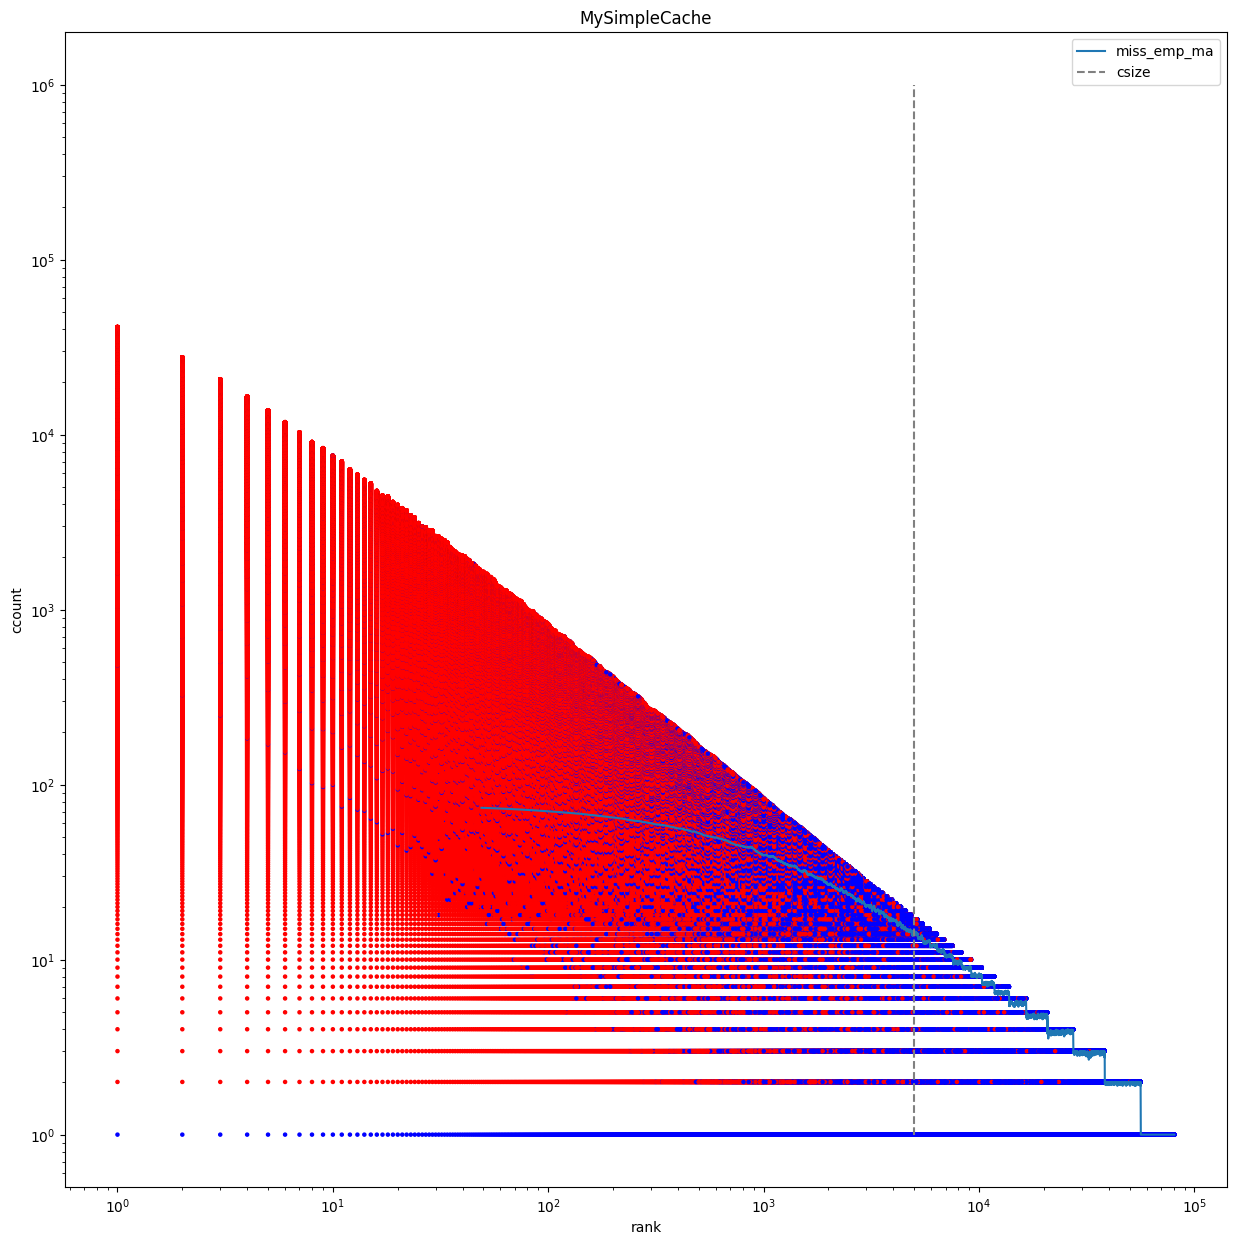

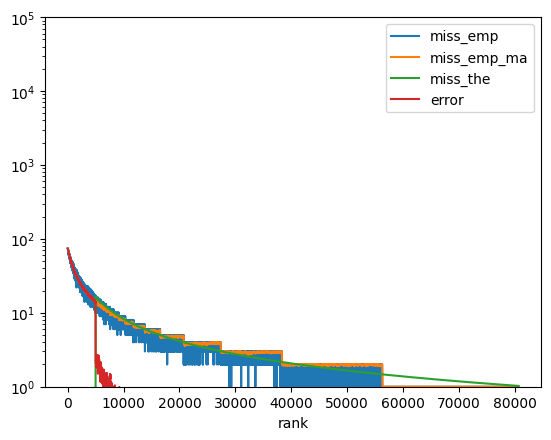

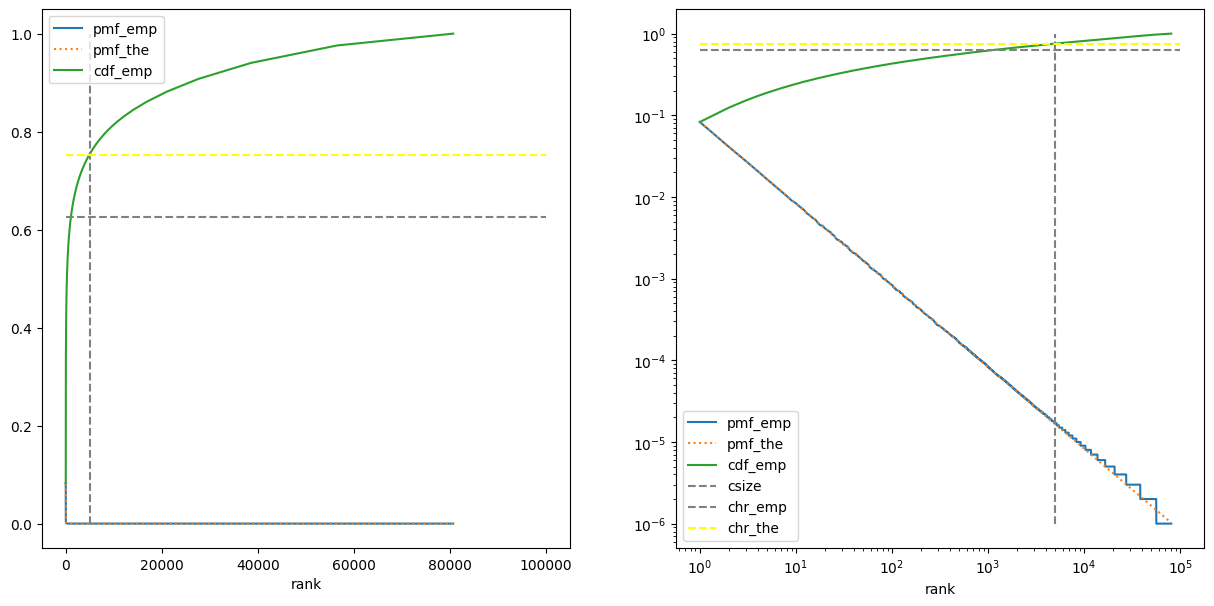

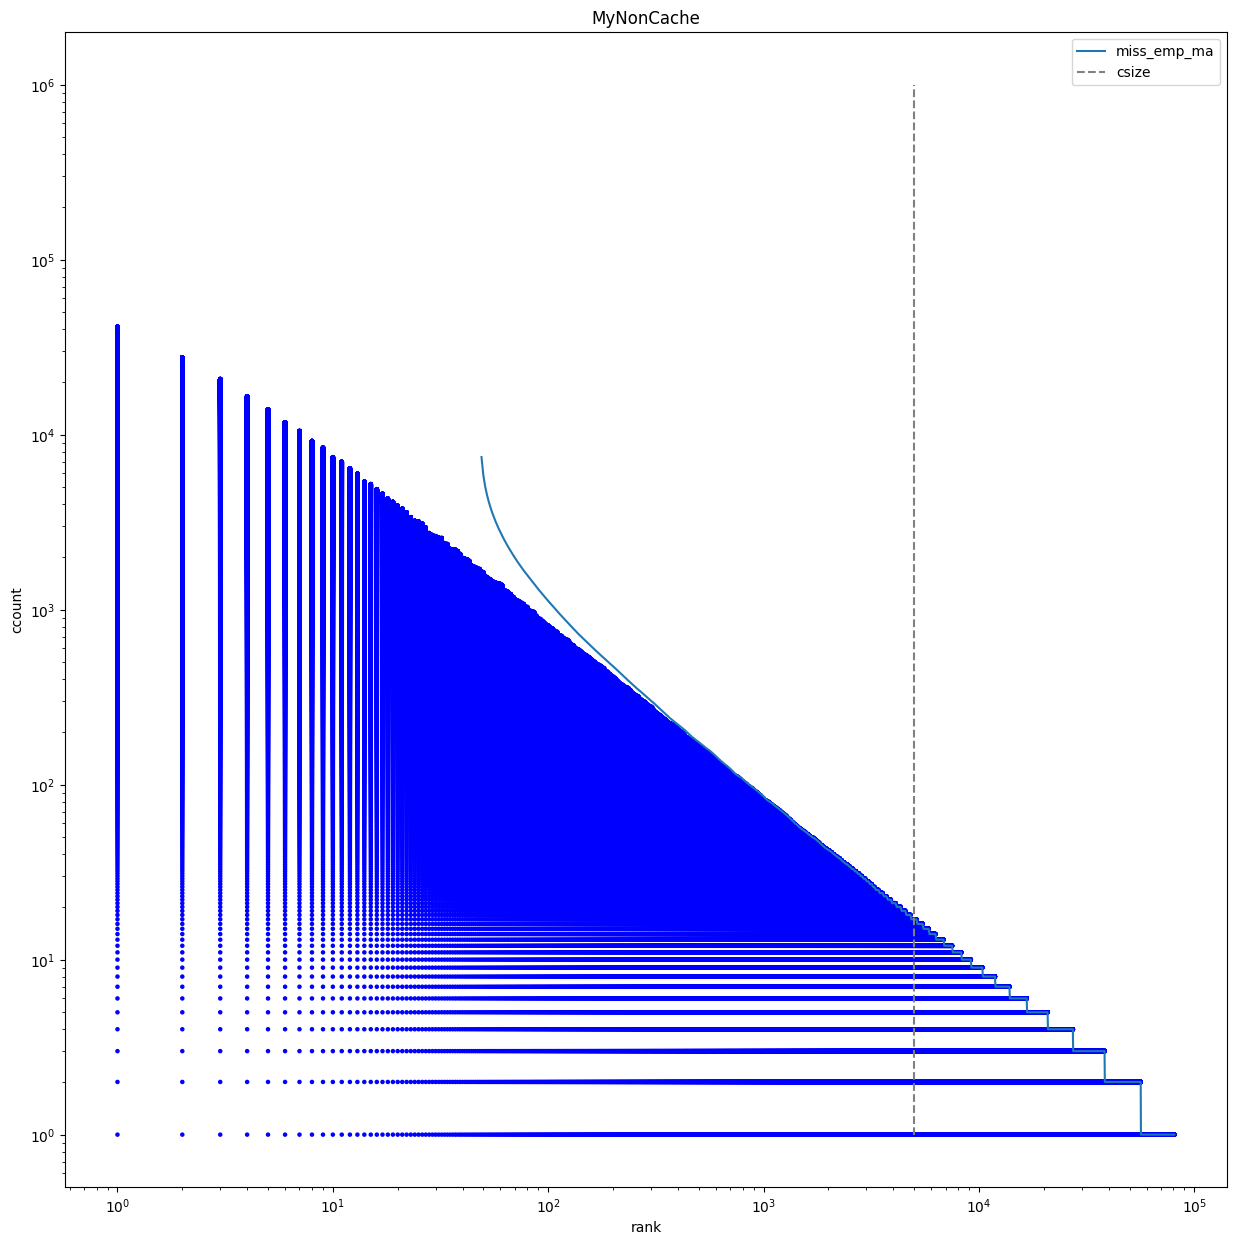

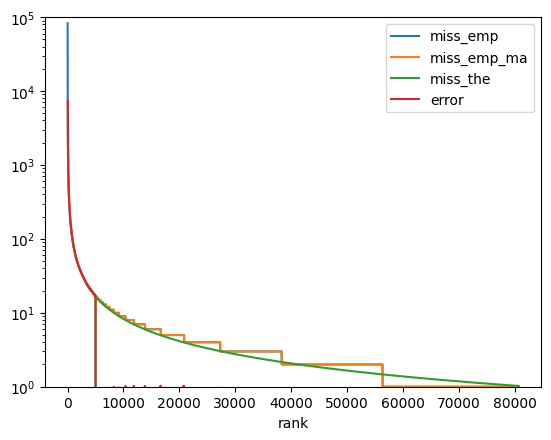

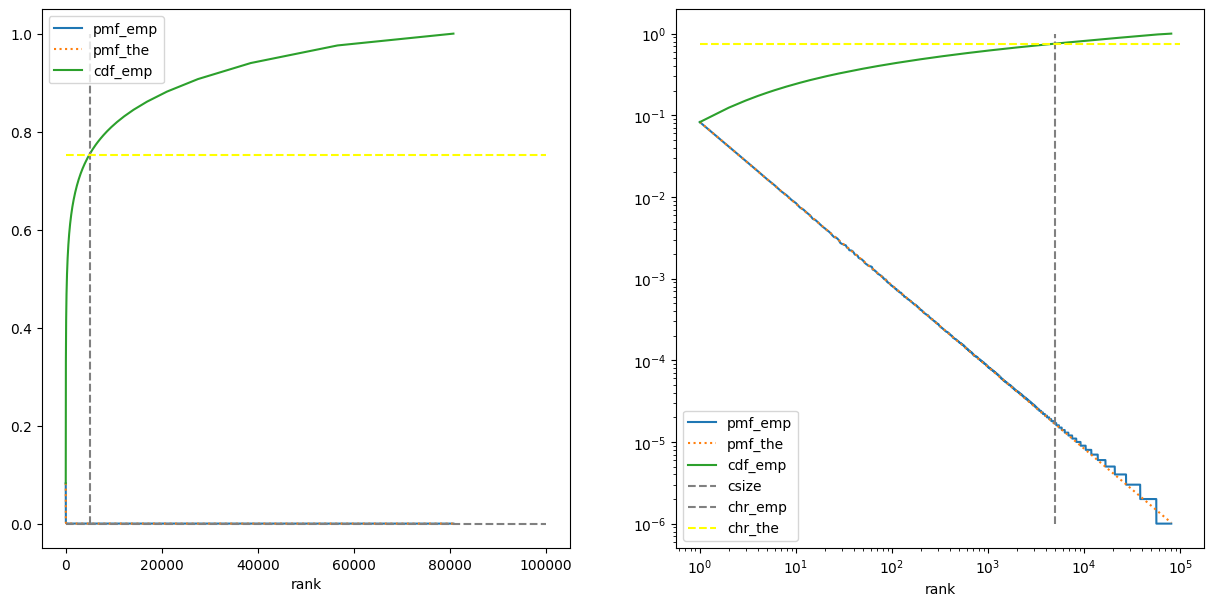

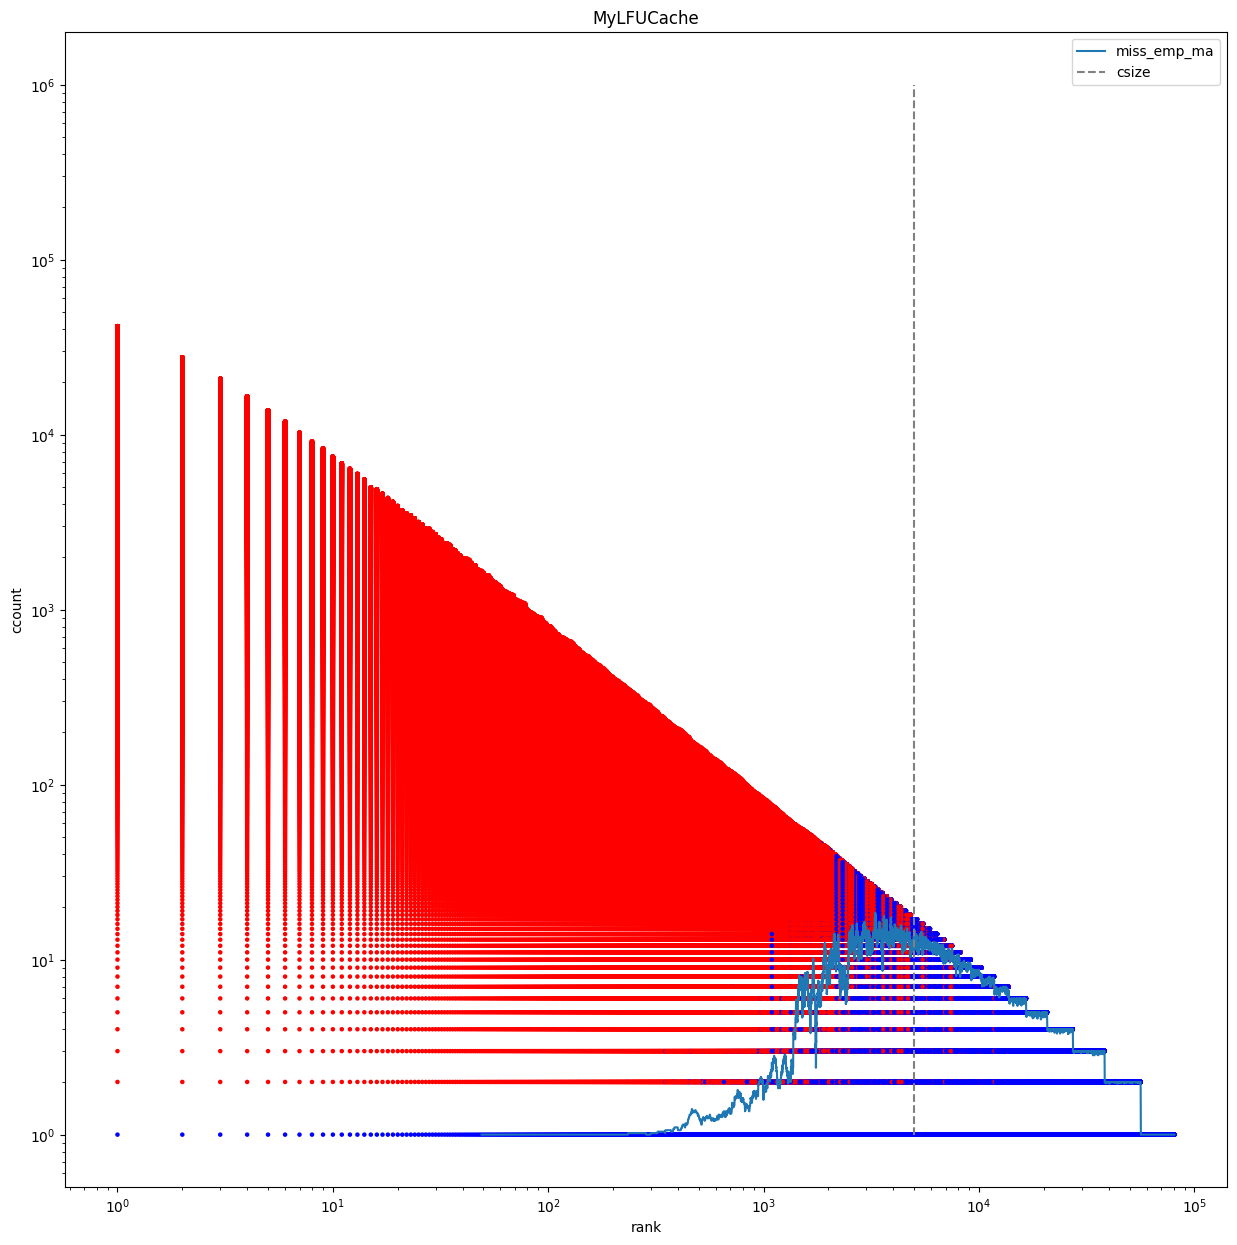

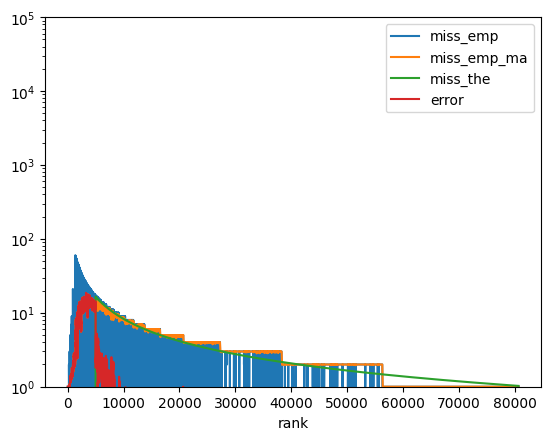

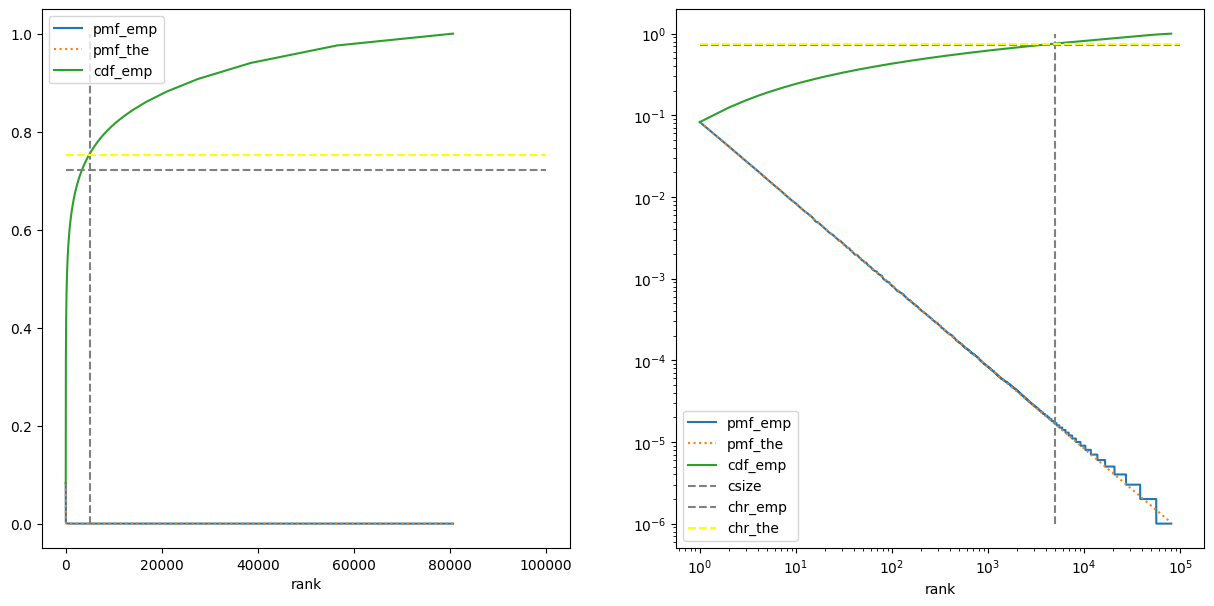

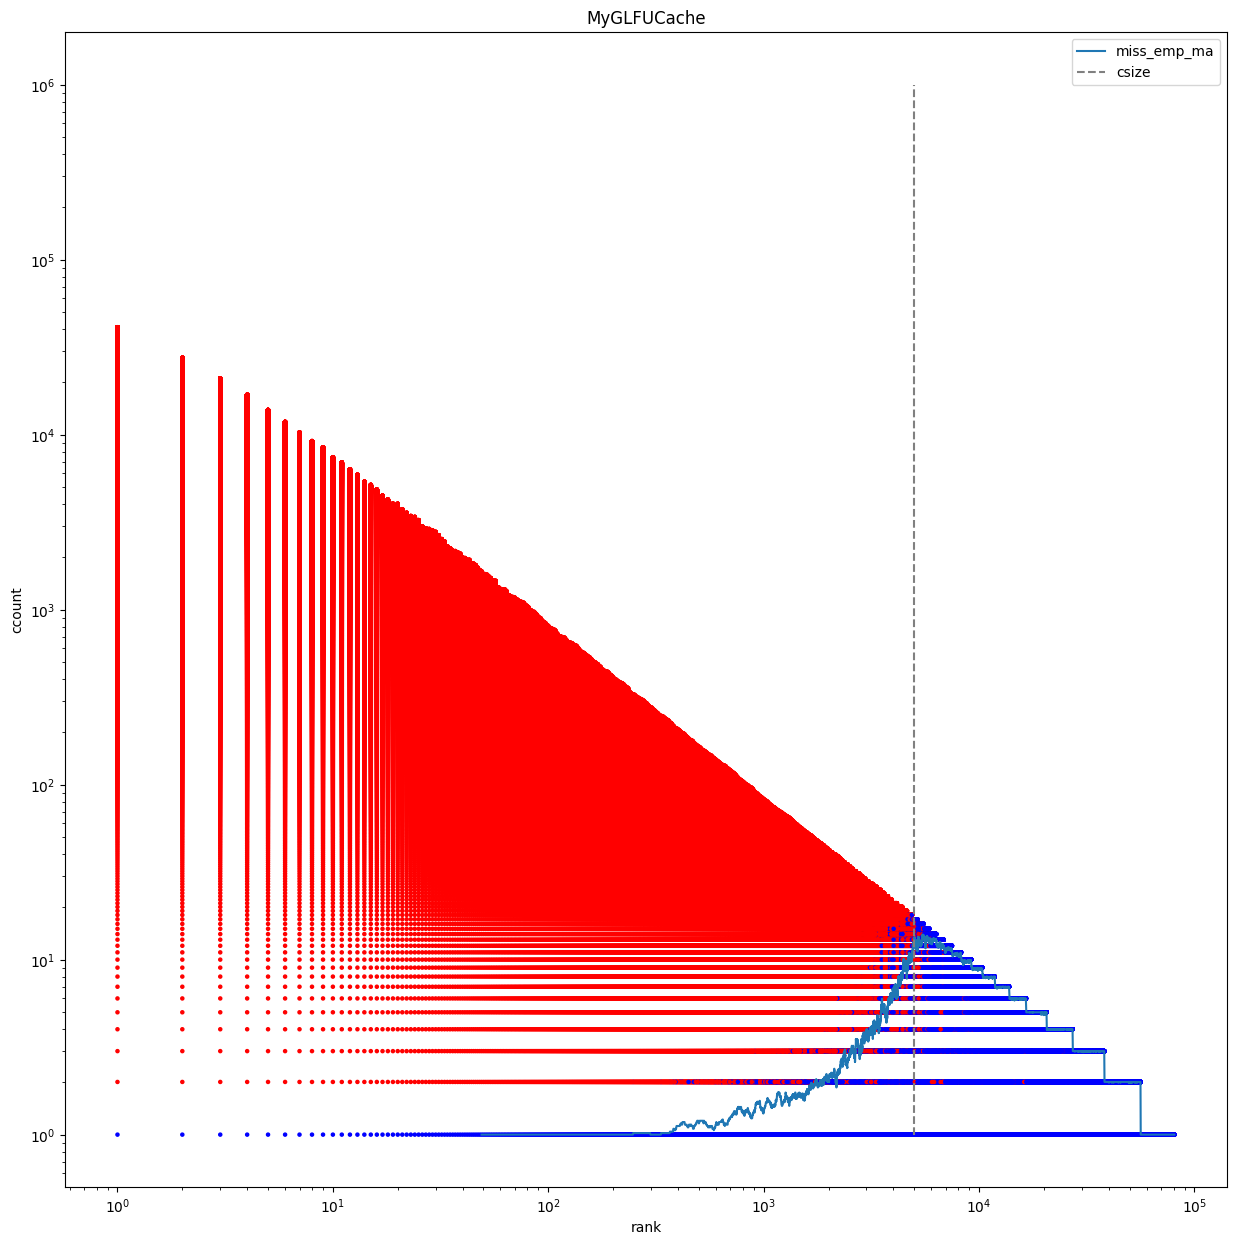

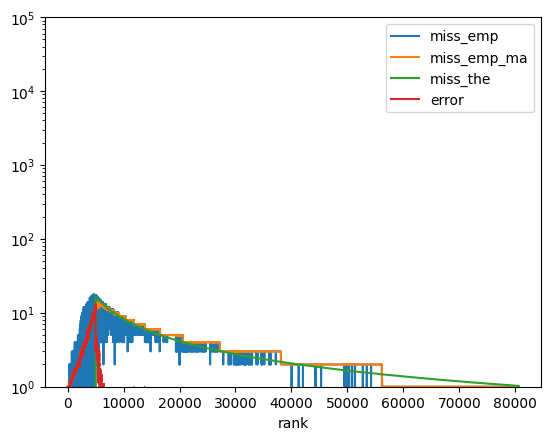

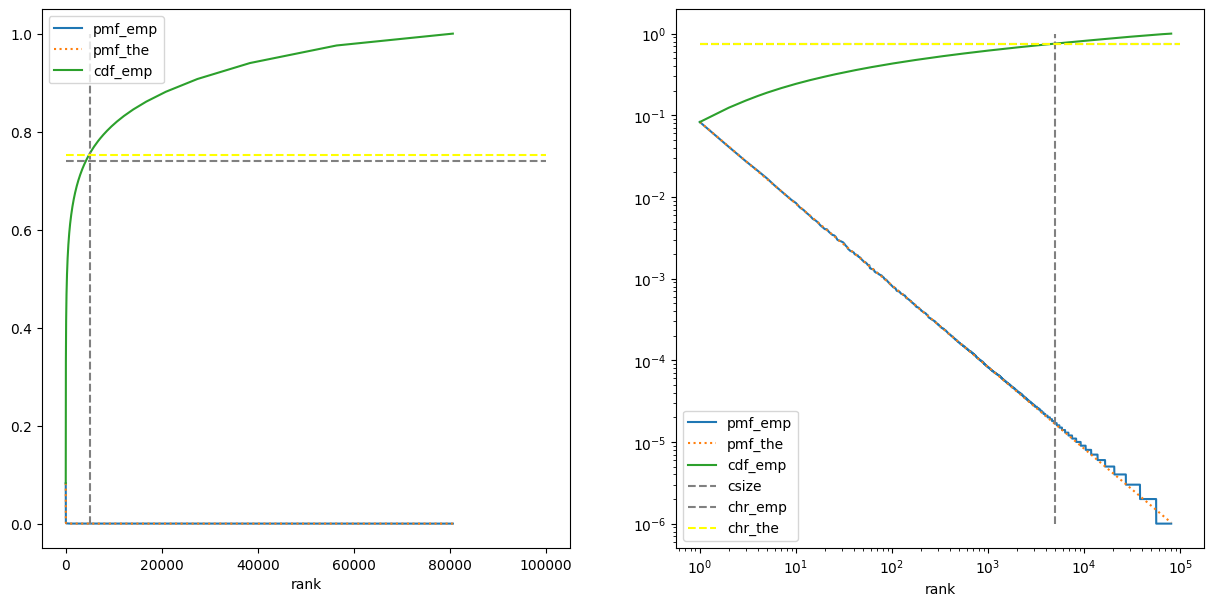

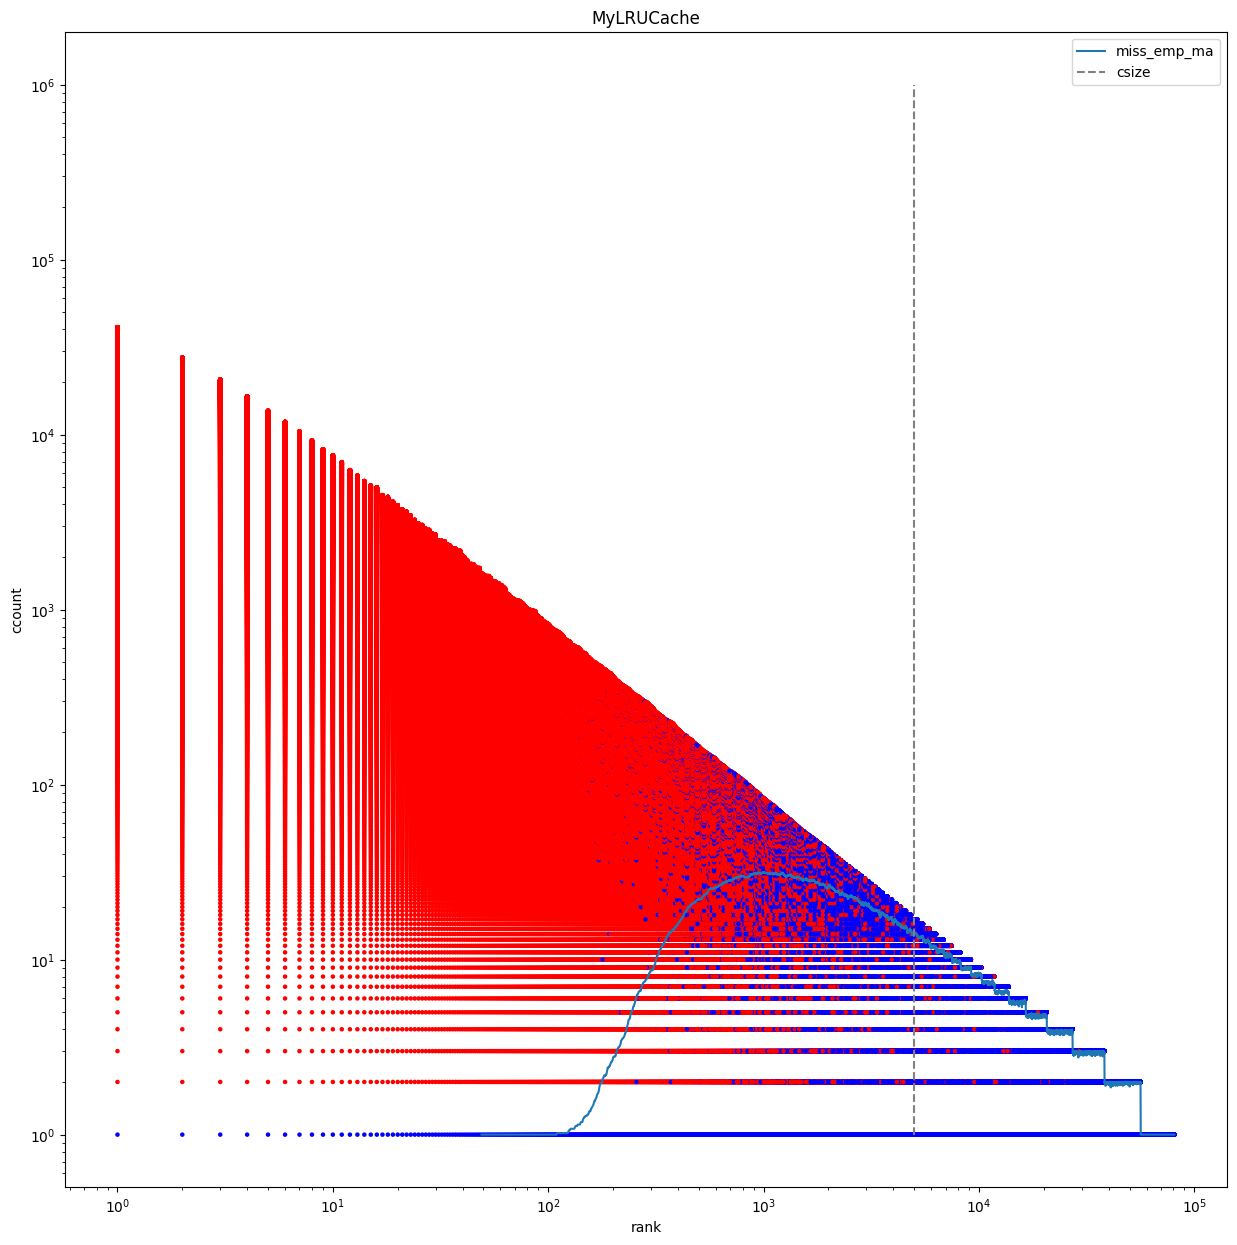

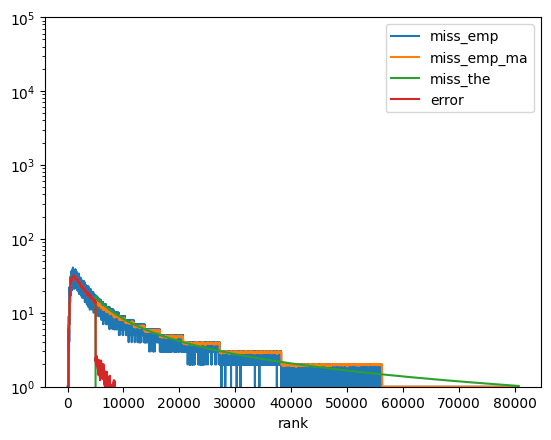

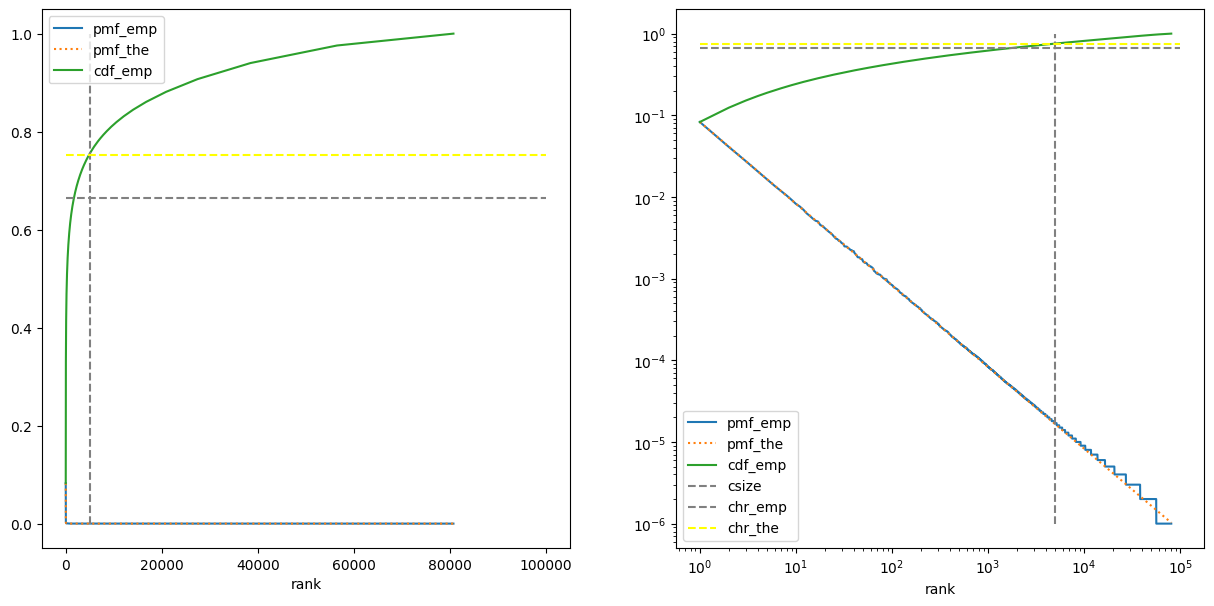

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

for name, req in reqs.items():
    # requests
    df_req = pd.DataFrame(data={'hitmiss': ['red' if r.status == Status.HIT else 'blue' for r in req], 'hash': [r.hash for r in req]}).set_index('hash')
    assert df_req.shape[0] == count
    assert not df_req.isnull().values.any()

    # calculate ranks
    df_ranks = pd.DataFrame(df_req.index.value_counts().index).reset_index(names='rank').set_index('hash')

    # join with ranks
    df = df_req.join(df_ranks)
    assert df.shape[0] == count
    assert not df.isnull().values.any()

    # add ccount
    df['ccount'] = df.groupby('rank').cumcount() + 1
    assert df.shape[0] == count
    assert not df.isnull().values.any()

    # calculate miss curve
    df_miss = df.groupby(['hitmiss', 'rank']).count().rename({'ccount': 'miss_emp'}, axis='columns').loc['blue']
    df_miss['miss_emp_ma'] = df_miss.rolling(50).mean()
    df_miss['miss_the'] = df_miss.index.map(lambda k: zipf_pmf(k) * count if k>maxsize else 0)
    df_miss['error'] = (df_miss['miss_the'] - df_miss['miss_emp_ma']).abs()

    _fig, ax = plt.subplots(figsize=(15,15))
    df.plot.scatter(ax=ax, x='rank', y='ccount', loglog=True, c='hitmiss', marker='.', figsize=(15,15), title=name)
#    df_miss.reset_index().plot.scatter(ax=ax, x='rank', y='miss_emp', loglog=True)
    df_miss.reset_index().plot(ax=ax, x='rank', y='miss_emp_ma', loglog=True)
    ax.vlines(maxsize, ymin=1, ymax=count, colors='grey', label="csize", linestyles='--')
    plt.legend()
    plt.show()
#    ('rank', 'ccount', data=df, s='.')
    # cache size
#    plt.vlines(maxsize, ymin=1, ymax=10**5, colors='grey', label="csize", linestyles='--')

    df_miss.plot(logy=True, ylim=(1, 10**5))
    plt.show()

    # misses
#    df_miss = pd.DataFrame(data={'hash': [r.hash for r in req], 'hitmiss': ['red' if r.status == Status.HIT else 'blue' for r in req]}).value_counts().groupby(['hash', 'hitmiss']).sum()
#    df_miss.loc[:,'blue'].plot(loglog=True, c='yellow', style='.', ms=1, label='miss')
#    df_miss.loc[:,'blue'].rolling(10).mean().plot(loglog=True, c='green', style='.', ms=2)
#    plt.legend()

    prop = pd.DataFrame(df_req.index.value_counts() / count).rename(columns={'count':'pmf_emp'})
    prop['rank'] = np.arange(prop.shape[0])+1
    prop['pmf_the'] = prop['rank'].apply(zipf_pmf)
    prop.set_index('rank', inplace=True)
    prop['cdf_emp'] = prop['pmf_emp'].cumsum()

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
    ax2.set_yscale('log')
    ax2.set_xscale('log')

    prop.plot(ax = ax1, style=['-', ':', '-'])
    ax1.vlines(maxsize, ymin=0, ymax=1, colors='grey', label="csize", linestyles='--')
    ax1.hlines(Request.chr(req), xmin=0, xmax=cbase, colors='grey', label="chr_emp", linestyles='--')
    ax1.hlines(zipf_cdf(maxsize), xmin=0, xmax=cbase, colors='yellow', label="chr_the", linestyles='--')

    prop.plot(ax = ax2, style=['-', ':', '-'])
    ax2.vlines(maxsize, ymin=10**-6, ymax=1, colors='grey', label="csize", linestyles='--')
    ax2.hlines(Request.chr(req), xmin=1, xmax=cbase, colors='grey', label="chr_emp", linestyles='--')
    ax2.hlines(zipf_cdf(maxsize), xmin=1, xmax=cbase, colors='yellow', label="chr_the", linestyles='--')
    plt.legend()
    plt.show()

In [60]:
df = pd.DataFrame(data={'hash': [r.hash for r in reqs['MyLFUCache']], 'hit': ['red' if r.status == Status.HIT else 'blue' for r in reqs['MyLFUCache']]}).value_counts().groupby(['hash', 'hit']).sum()
df.loc[:,'blue'].rolling(100).mean().plot(loglog=True)
df


hash   hit 
0      blue        1
       red     82934
1      blue        1
       red     41282
2      blue        1
               ...  
99992  blue        1
99993  blue        1
99996  blue        3
99998  blue        1
99999  blue        2
Name: count, Length: 81805, dtype: int64

<Axes: xlabel='hash'>

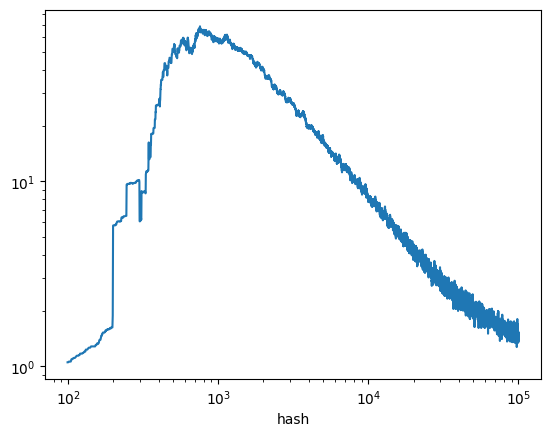

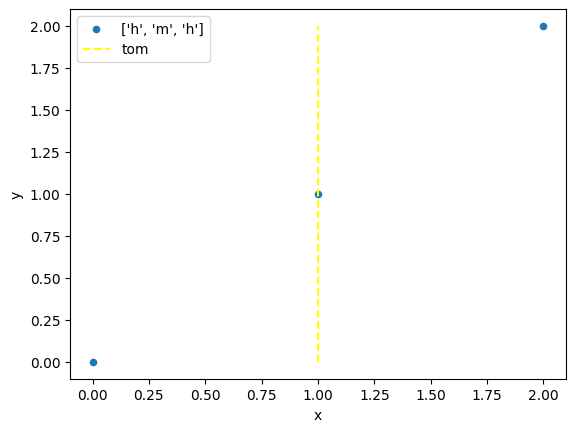

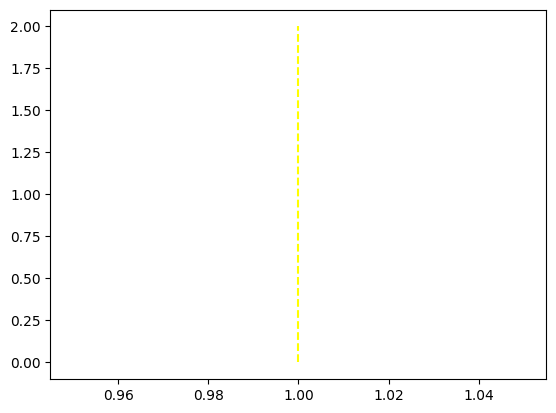

In [34]:
pd.DataFrame({'x':[0,1,2],'y':[0,1,2] }).plot.scatter(x='x', y='y', label=['h', 'm', 'h'])
plt.vlines(1, ymin=0, ymax=2, label="tom", colors='yellow', linestyles='--')
plt.legend()
plt.show()
plt.vlines(1, ymin=0, ymax=2, label="tom", colors='yellow', linestyles='--')


hash
4    4
0    2
1    1
3    1
Name: count, dtype: int64

In [55]:
a

,a
0,0
1,1
2,2
3,3
4,4
5,6
6,7
7,9


In [56]:
a['a'].unique()

array([0, 1, 2, 3, 4, 6, 7, 9], dtype=int64)

In [90]:
a = pd.DataFrame(data={'hash':[0,1,0,3,4,4,4,4]})
prop = pd.DataFrame(a['hash'].value_counts()).rename(columns={'count': 'pdf'})
prop['cdf'] = prop['pdf'].cumsum()
prop

,pdf,cdf
hash,,
4,4,4
0,2,6
1,1,7
3,1,8


<Axes: >

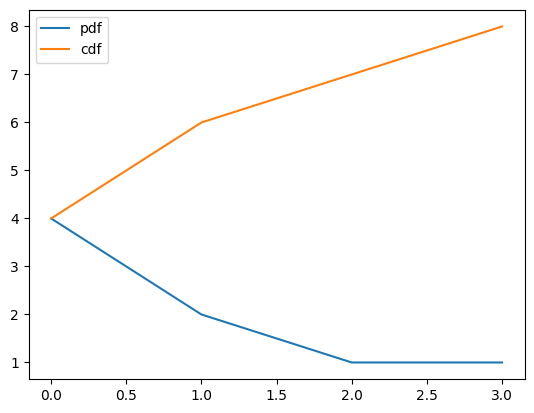

In [100]:

prop.plot(use_index=False, xlabel='hash')
